# Variable Conversion

## やること
　目的変数(観客数)を直接予測するのではなく, 試合の行われるスタジアムの収容率を予測して、最後に
観客数に戻すことを行う。

### 手順
　収容率は、目的変数(観客数)÷スタジアム収容人数で表され、スタジアムの収容人数を1としてどれくらいの割合観客が来たかを意味しています。収容率は割合なので\[0,1\]の値を取るように下限・上限が存在するため、今まで通り収容率そのものに重回帰を適用しようとすると上手くいきません。<br>
　今回は、以前の講座でお話しした対数オッズを利用します。対数オッズに変換することで\[0,1\]の値域を$[-\infty, \infty]$に変換することが出来ます。収容率を直接予測するのではなくその対数オッズを予測するようにします。


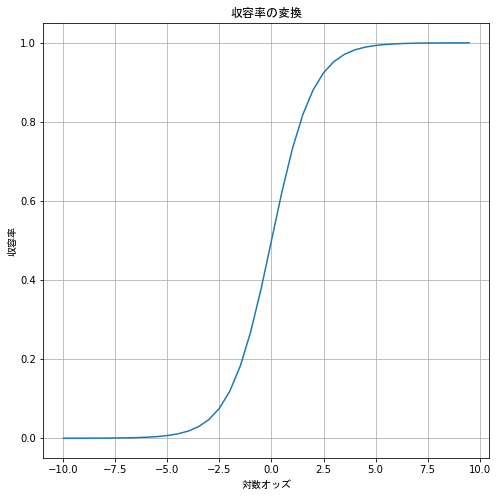

下記の様な手順を踏みます。 
 
 1. 目的変数を収容率に変換. $y_1$:観客動員数, capa:スタジアム収容人数とします. この変換により$y_2$は$[0,1]$区間内の値をとる収容率を意味します.
 
<div style="text-align: center;">
$y_2 = \dfrac{y_1}{\mathrm{capa}}.$
</div>  

2. 次に, 対数オッズに変換します. この変換により$[0,1]$区間の値である収容率$y_2$を$[-\infty, \infty]$の区間の値とする収容率の対数オッズに変換します.
<div style="text-align: center;">
$y_3 = \log\left(\dfrac{y_2}{1-y_2}\right).$
</div>

3. この$y_3$を線形回帰モデルを用いて予測します. このとき, 変数加工(変数作成, 線形化など)やデータ加工(欠損, 外れ値処理), 変数選択(変数同士の相関確認)などを忘れないように注意します.

4. 予測された$\hat{y}_3$を収容率$\hat{y}_2$に戻します. このとき, 対数オッズ変換の逆関数はロジスティック関数となります.
<div style="text-align: center;">
$\hat{y}_2 = \dfrac{1}{1+e^{-\hat{y}_3}}.$
</div>

5. 最後に収容率$\hat{y}_2$から観客数$\hat{y}_1$に変換します.
<div style="text-align: center;">
$\hat{y}_1 = \mathrm{capa}\times\hat{y}_2.$
</div>

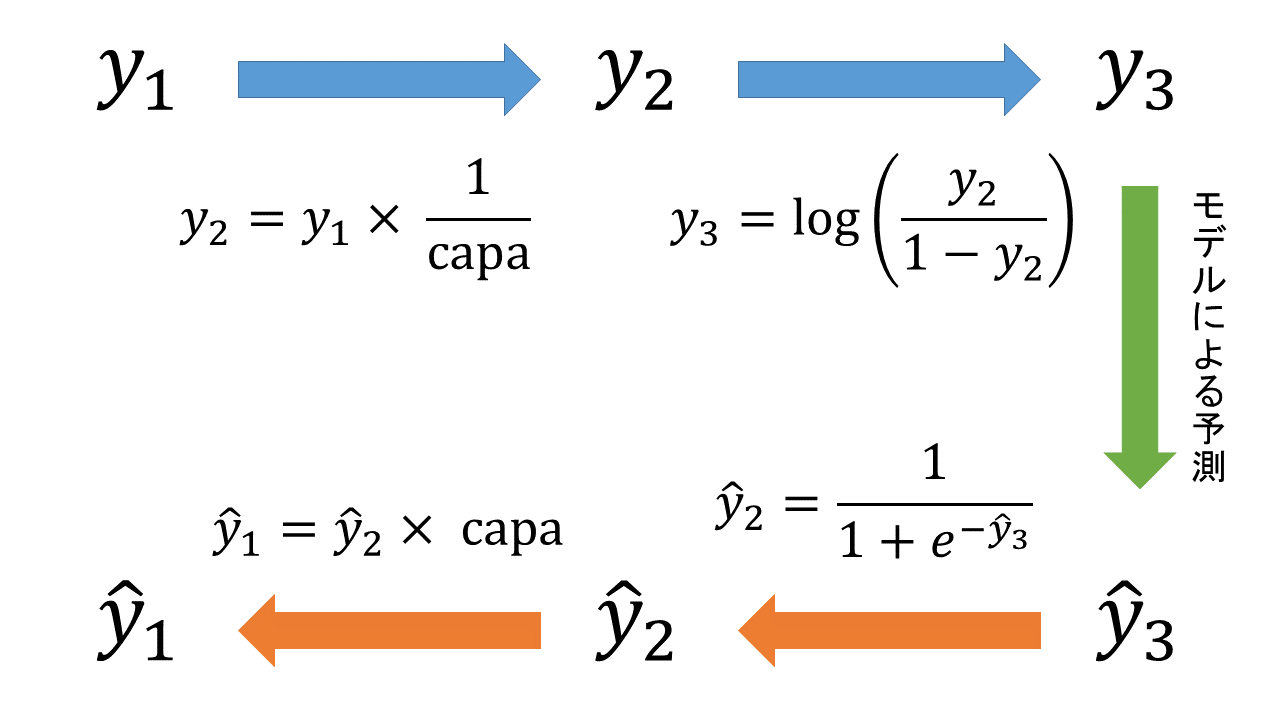

## 実践
　実際に, 以前もご紹介したTV放送数を用いて, 比較を行う.

### モジュールの読み込み

In [1]:
# 多次元配列やデータフレームの操作
import numpy as np
import pandas as pd

# 線形回帰モデル
from sklearn.linear_model import LinearRegression

# グラフの描画
from matplotlib import pyplot as plt
import seaborn as sns

### パスの設定

In [2]:
# 入力ファイルの場所
input_path = '../input_data/jleague/'

# 提出ファイルを出力する場所
submit_path = '../submit/jleague/'

### データ読込

In [3]:
# 試合データ
train = pd.read_csv(input_path + 'train.csv')
test = pd.read_csv(input_path + 'test.csv')

# スタジアムデータ
stadium = pd.read_csv(input_path + 'stadium.csv')

#試合詳細データ
condition = pd.read_csv(input_path + 'condition.csv')

### データ結合

In [4]:
# trainとconditionを対戦カードidを基準に結合
tmp1 = pd.merge(train, condition, how='left', on='id')

# testとconditionを対戦カードidを基準に結合
tmp2 = pd.merge(test, condition, how='left', on='id')

# 結合(基準とする変数名が違うので注意)
train_new = pd.merge(tmp1, stadium, how='left', left_on='stadium', right_on='name')
test_new = pd.merge(tmp2, stadium, how='left', left_on='stadium', right_on='name')


# 観客数0の試合は除く(異常値なのと, 対数オッズが発散するため)
train_new = train_new[train_new['y'] != 0]

# 予測するy_3の作成
train_new['y_2'] = train_new['y'] / train_new['capa']
train_new['y_3'] = np.log(train_new['y_2'] / (1-train_new['y_2']))

# TV放送数の追加
train_new['tv_num'] = train_new['tv'].str.split( "／").apply(len) -1
test_new['tv_num'] = test_new['tv'].str.split( "／").apply(len) -1


### データ確認
　実際の収容率の範囲とTV放送数の線形性チェック。

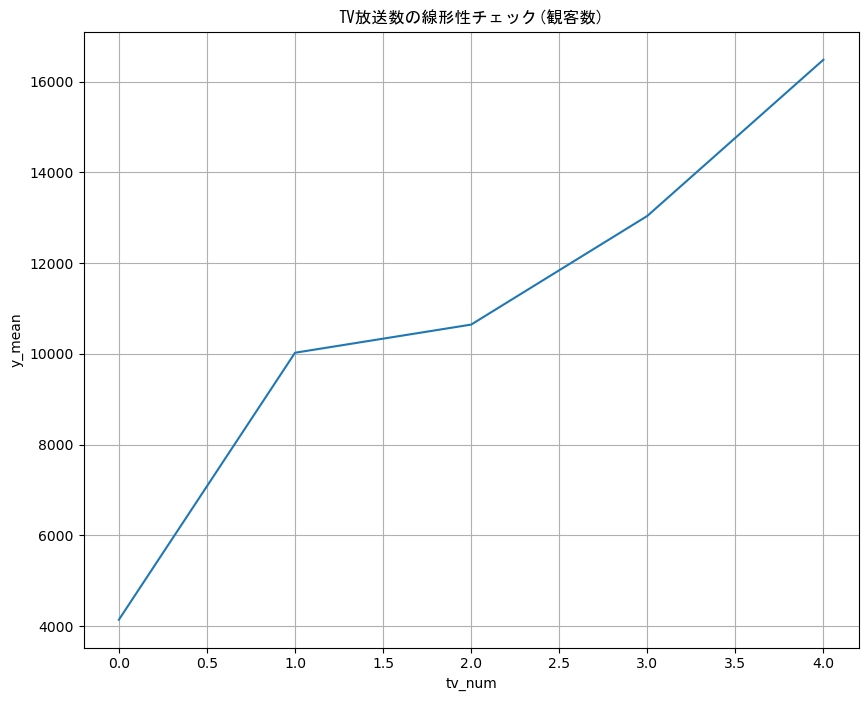

In [5]:
# TV放送数の線形性チェック(観客数)
# チェックする変数の設定
x_var = 'tv_num'
y_var = 'y'

tmp = train_new.groupby(x_var,as_index = False)[y_var].mean()
tmp = tmp.rename(columns={y_var: y_var+'_mean'})

plt.figure(figsize=(10, 8))
sns.lineplot(data=tmp, x=x_var, y=y_var+'_mean')
plt.grid()
plt.title('TV放送数の線形性チェック(観客数)', fontname="MS Gothic")
plt.show()

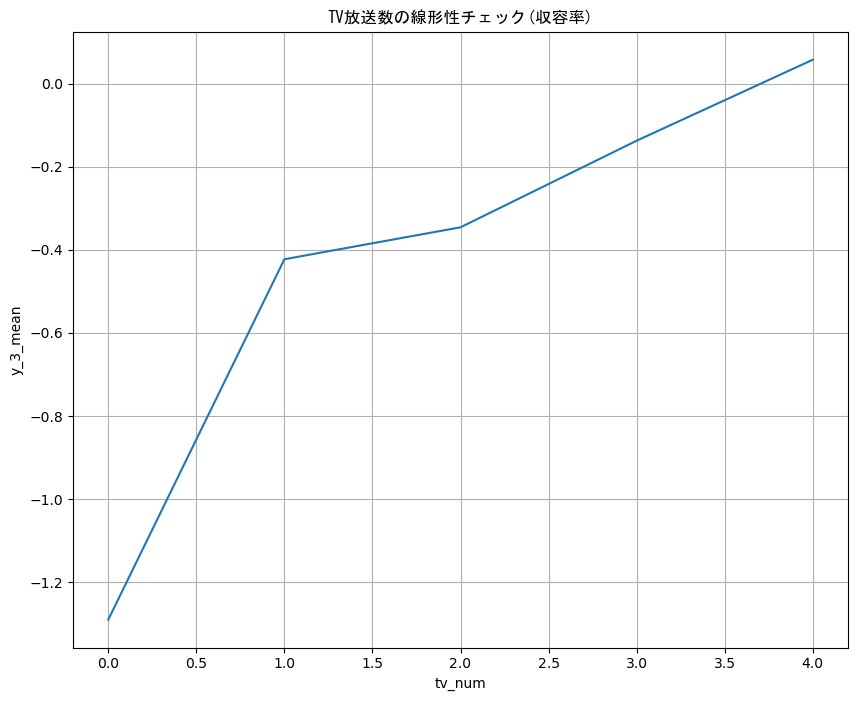

In [6]:
# TV放送数の線形性チェック(観客数)
# チェックする変数の設定
x_var = 'tv_num'
y_var = 'y_3'

tmp = train_new.groupby(x_var,as_index = False)[y_var].mean()
tmp = tmp.rename(columns={y_var: y_var+'_mean'})

plt.figure(figsize=(10, 8))
sns.lineplot(data=tmp, x=x_var, y=y_var+'_mean')
plt.grid()
plt.title('TV放送数の線形性チェック(収容率)', fontname="MS Gothic")
plt.show()

### データ加工
　観客数のtv_numを線形化するために、tv_num = 0を-1に変換。 収容率のtv_num2を線形化するために、tv_num2 = 0を-2に変換。

In [7]:
# 変換した特徴量の作成
train_new['tv_num_1'] = train_new['tv_num'].where(train_new['tv_num'] != 0, -1)
test_new['tv_num_1'] = test_new['tv_num'].where(test_new['tv_num'] != 0, -1)

train_new['tv_num_2'] = train_new['tv_num'].where(train_new['tv_num'] != 0, -2)
test_new['tv_num_2'] = test_new['tv_num'].where(test_new['tv_num'] != 0, -2)

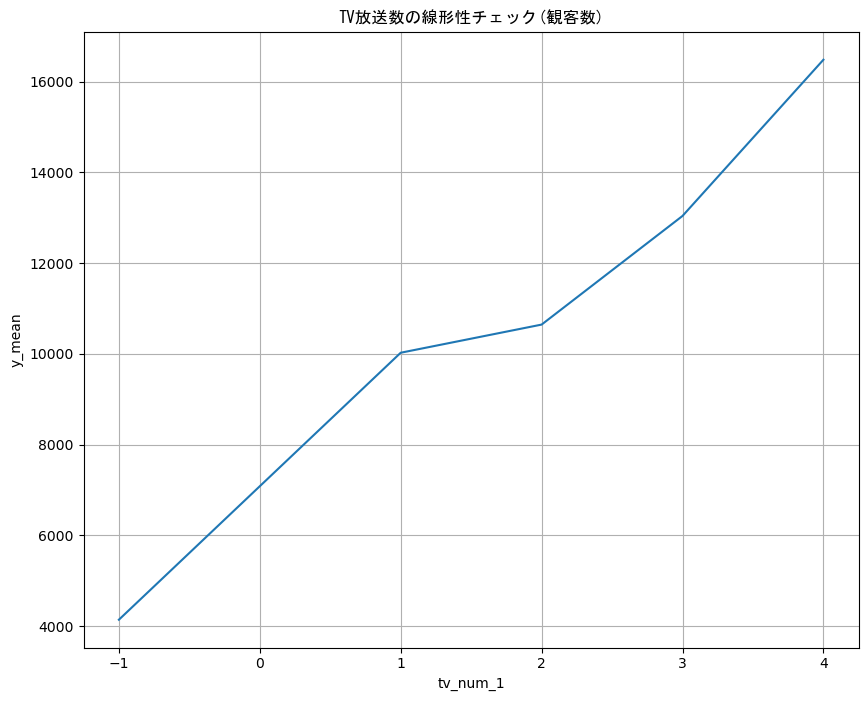

In [8]:
# TV放送数の線形性チェック(観客数)
# チェックする変数の設定
x_var = 'tv_num_1' #変換したtv_num
y_var = 'y'

tmp = train_new.groupby(x_var,as_index = False)[y_var].mean()
tmp = tmp.rename(columns={y_var: y_var+'_mean'})

plt.figure(figsize=(10, 8))
sns.lineplot(data=tmp, x=x_var, y=y_var+'_mean')
plt.grid()
plt.title('TV放送数の線形性チェック(観客数)', fontname="MS Gothic")
plt.show()

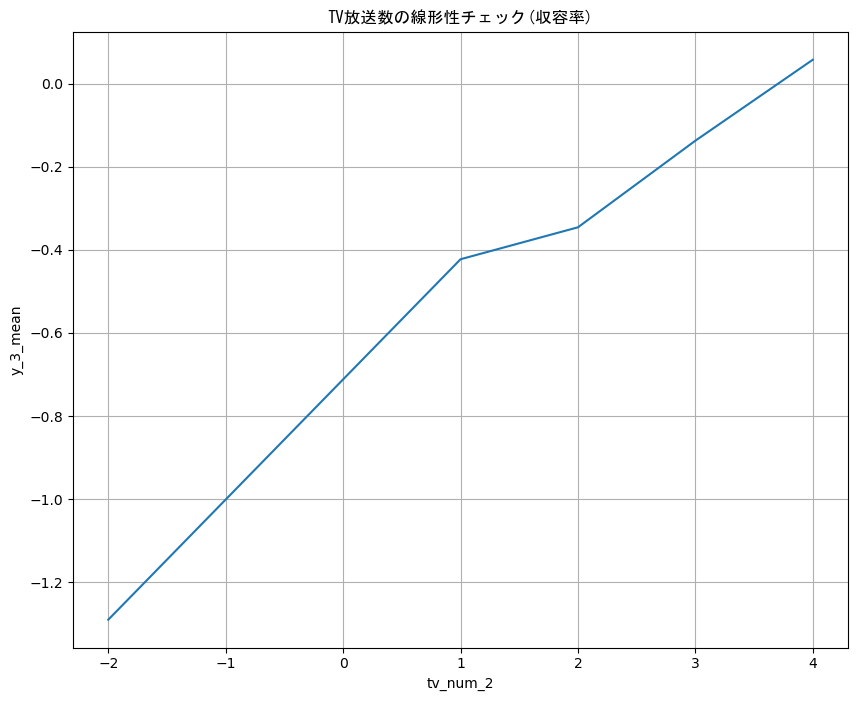

In [9]:
# TV放送数の線形性チェック(収容率)
# チェックする変数の設定
x_var = 'tv_num_2'  #変換したtv_num
y_var = 'y_3'

tmp = train_new.groupby(x_var,as_index = False)[y_var].mean()
tmp = tmp.rename(columns={y_var: y_var+'_mean'})

plt.figure(figsize=(10, 8))
sns.lineplot(data=tmp, x=x_var, y=y_var+'_mean')
plt.grid()
plt.title('TV放送数の線形性チェック(収容率)', fontname="MS Gothic")
plt.show()

### モデル作成, 予測
　単回帰にてモデル作成し、予測値を出します。
 観客数と収容率、それぞれモデルを作成して結果を見ます。

In [10]:
######### 観客数
# 観客数を予測するモデルの構築
reg_all = LinearRegression()
reg_all = reg_all.fit(train_new[['tv_num_1']], train_new['y'])

# 投稿データに対して予測値を計算
test_new['pred_1'] = reg_all.predict(test_new[['tv_num_1']])

# submit形式に整える
# capa越え、非負補正
test_new['pred_1'] = test_new['pred_1'].clip(lower = 0, upper = test_new['capa'])

submit_1 = test_new[['id', 'pred_1']].copy()

In [11]:
######### 収容率
# 収容率の対数オッズを予測するモデルの構築
reg_all = LinearRegression()
reg_all = reg_all.fit(train_new[['tv_num_2']], train_new['y_3'])

# 投稿データに対して予測値を計算
test_new['pred_2_tmp'] = reg_all.predict(test_new[['tv_num_2']])

# 収容率の対数オッズから観客数に戻す
test_new['pred_2'] = test_new['capa'] * (1 / (1 + np.exp(-test_new['pred_2_tmp'])))

# submit形式に整える
submit_2 = test_new[['id', 'pred_2']].copy()

### 投稿結果の比較
　実際に投稿して、スコアを確認する。


In [12]:
# CSV出力(ヘッダーなし)
submit_1.to_csv(submit_path + 'submit_lm_1.csv', index=False, header=False)

# CSV出力(ヘッダーなし)
submit_2.to_csv(submit_path + 'submit_lm_2.csv', index=False, header=False)


- 観客数を予測した時 → 7886
- 収容率を予測した時 → 5941

今回の例ではスコア向上が確認できた.